In [70]:
import pandas as pd
import numpy as np
import copy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import scipy as sc
import plotly.graph_objects as go
# import sqlite3
# from pypfopt.expected_returns import mean_historical_return
# from pypfopt.risk_models import CovarianceShrinkage
# from pypfopt.efficient_frontier import EfficientFrontier
# import pypfopt.plotting as plotting
import seaborn as sns



In [71]:
end_date = datetime.today()
start_date = end_date - timedelta(days=3000)
tickers = ["AAL","BABA","META","AAPL"]
weights = [20, 40, 20, 20]

In [72]:
# Import data
def getData(tickers:list, start_date:datetime, end_date:datetime):
    
    df = yf.download(tickers,
                    start=start_date,
                    end=end_date
                    )
    df = df['Adj Close']
    
    # mu = mean_historical_return(df)
    # S = CovarianceShrinkage(df).ledoit_wolf()
    # returns = df.pct_change()
    # meanReturns = returns.mean()
    # covMatrix = returns.cov()
    return df

df = getData(tickers, start_date, end_date)

# Calculate daily and annual returns of the stocks
returns_daily = df.pct_change()
returns_annual = returns_daily.mean() * 252

# Get daily and covariance of returns of the stocks
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 252

# Actual portfolio return, volatility and sharpe
def return_performance(weights, returns_annual):
    weights /= np.sum(weights)
    return_perf = np.dot(weights, returns_annual)
    return return_perf

def volatility_performance(weights, cov_annual):
    weights /= np.sum(weights)
    volatility_perf = np.sqrt(np.dot(np.array(weights).T, np.dot(cov_annual, weights)))
    return volatility_perf


actual_volatility = volatility_performance(weights, cov_annual)
actual_return = return_performance(weights, returns_annual)    
actual_sharpe = actual_return / actual_volatility

# a dictionary for Returns and Risk values of each portfolio
actual_portfolio = {'Returns': actual_return,
            'Volatility': actual_volatility,
            'Sharpe Ratio': actual_sharpe}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(tickers):
    actual_portfolio[symbol+' weight'] = weights[counter]

# make a nice dataframe of the extended dictionary
actual_portfolio_df= pd.DataFrame.from_dict(actual_portfolio, orient='index').T

df.head()
actual_portfolio_df

[*********************100%***********************]  4 of 4 completed


,Returns,Volatility,Sharpe Ratio,AAL weight,BABA weight,META weight,AAPL weight
0,0.152127,0.278737,0.545772,20.0,40.0,20.0,20.0


In [73]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

# set the number of combinations for imaginary portfolios
num_assets = len(tickers)
num_portfolios = 60000

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    # generate random weights and normalize.
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)

    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility

    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
            'Volatility': port_volatility,
            'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(tickers):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)


# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility','Sharpe Ratio'] + [stock+' weight' for stock in tickers]

# reorder dataframe columns
df = df[column_order]


# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
# find max Volatility & max Returns values in the dataframe (df) for x_lim and y_lim
max_volatility = df['Volatility'].max()
max_return = df['Returns'].max()
min_return = df['Returns'].min()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# Plot tangent, best ratio Return(mean)/Volatility(std dev)
tangent = df.loc[(df['Returns']/df['Volatility']).idxmax()]
x_tangent = [0,tangent['Volatility'],1]
y_tangent = [0,tangent['Returns'],tangent['Returns']/tangent['Volatility']]

# Actual portfolio Return and Volatility
x_actual = [actual_volatility]
y_actual = [actual_return]


In [74]:
df.head()

,Returns,Volatility,Sharpe Ratio,AAL weight,BABA weight,META weight,AAPL weight
0,0.136934,0.312866,0.437677,0.401223,0.443388,0.022123,0.133266
1,0.144913,0.289754,0.500122,0.251963,0.306608,0.112865,0.328564
2,0.073861,0.325520,0.226900,0.396923,0.104486,0.304882,0.193709
3,0.141534,0.292586,0.483735,0.084002,0.362809,0.445883,0.107306
4,0.150109,0.291519,0.514921,0.049376,0.356635,0.430760,0.163229


In [75]:
# Find optimal return portfolio for actual Volatility and Return

closest_volatility = df.iloc[(df['Volatility']-(actual_volatility)).abs().argsort()[:10]]
max_return_for_volatility = closest_volatility[closest_volatility['Returns']==closest_volatility['Returns'].max()]

closest_return = df.iloc[(df['Returns']-actual_return).abs().argsort()[:10]]
min_volatility_for_return = closest_return[closest_return['Volatility']==closest_return['Volatility'].min()]

min_volatility_for_return
max_return_for_volatility

print(f'''Max Return for actual volatility : {max_return_for_volatility['Volatility'].values[0] :.4f}
        {max_return_for_volatility.iloc[:,-len(tickers):].to_dict('records')}
        ''')
print(f'''Min Volability for actual Return : {min_volatility_for_return['Returns'].values[0] :.4f}
        {min_volatility_for_return.iloc[:,-len(tickers):].to_dict('records')}
        ''')

Max Return for actual volatility : 0.2787
        [{'AAL weight': 0.03271147501727739, 'BABA weight': 0.4543630818857652, 'META weight': 0.20929030731150192, 'AAPL weight': 0.3036351357854554}]
        
Min Volability for actual Return : 0.1521
        [{'AAL weight': 0.2180698983318344, 'BABA weight': 0.46330128974231805, 'META weight': 0.21141768189245244, 'AAPL weight': 0.10721113003339498}]
        


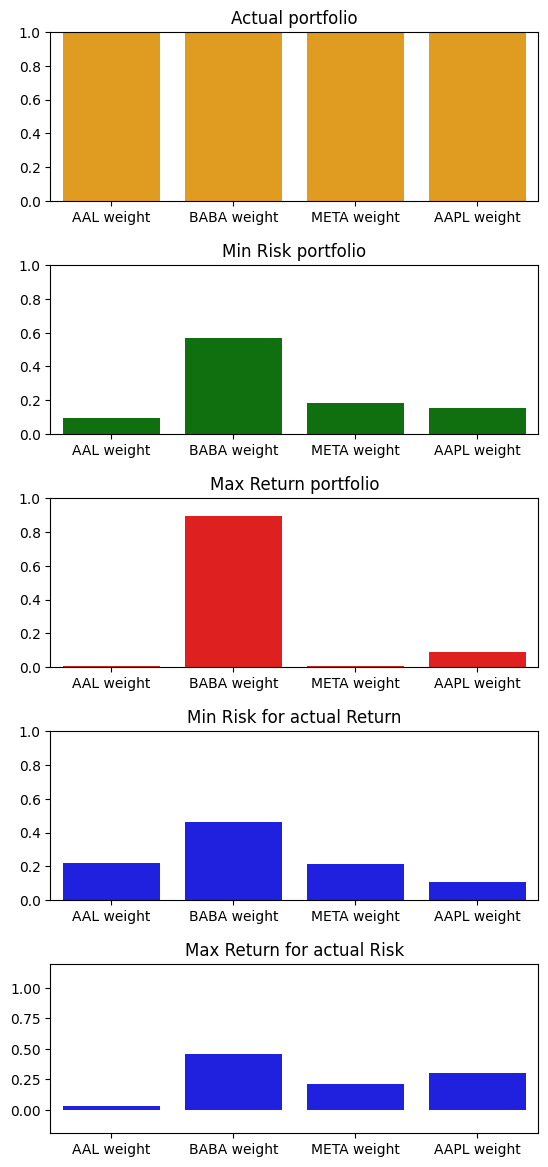

In [76]:
def plot_weights ():
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(6, 12))
    fig.tight_layout(pad=2.5)
    plt.axis('equal')

    sns.barplot(actual_portfolio_df.iloc[:,-len(tickers):], color='orange', ax=ax1)
    sns.barplot(min_variance_port.iloc[:,-len(tickers):], color='green', ax=ax2)
    sns.barplot(sharpe_portfolio.iloc[:,-len(tickers):], color='red',ax=ax3)
    sns.barplot(min_volatility_for_return.iloc[:,-len(tickers):], color='blue', ax=ax4)
    sns.barplot(max_return_for_volatility.iloc[:,-len(tickers):], color='blue', ax=ax5)

    ax1.set_title('Actual portfolio')
    ax2.set_title('Min Risk portfolio')
    ax3.set_title('Max Return portfolio')
    ax4.set_title('Min Risk for actual Return')
    ax5.set_title('Max Return for actual Risk')

    ax1.set_ylim(0,1)
    ax2.set_ylim(0,1)
    ax3.set_ylim(0,1)
    ax4.set_ylim(0,1)
    ax5.set_ylim(0,1)

    plt.show()
    # optimisation_plot = './fastAPI/graphs/optimisation_plot.png'
    # with open(optimisation_plot, mode='w') as f:
    #     plt.savefig(optimisation_plot, dpi='figure', format='png', metadata=None,
    #         bbox_inches='tight', pad_inches=0.1,
    #         facecolor='auto', edgecolor='auto',
    #         backend=None
    #     )
    plt.close()
    
plot_weights()

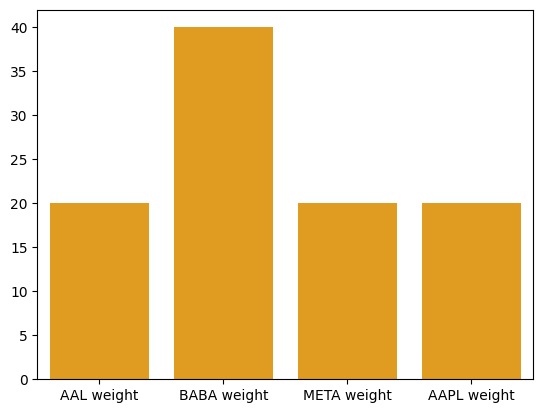

In [77]:
ax1 = sns.barplot(sharpe_portfolio.iloc[:,-len(tickers):], color='red')
ax2 = sns.barplot(min_variance_port.iloc[:,-len(tickers):], color='green')
ax3 = sns.barplot(actual_portfolio_df.iloc[:,-len(tickers):], color='orange')

c:\Python311\Lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


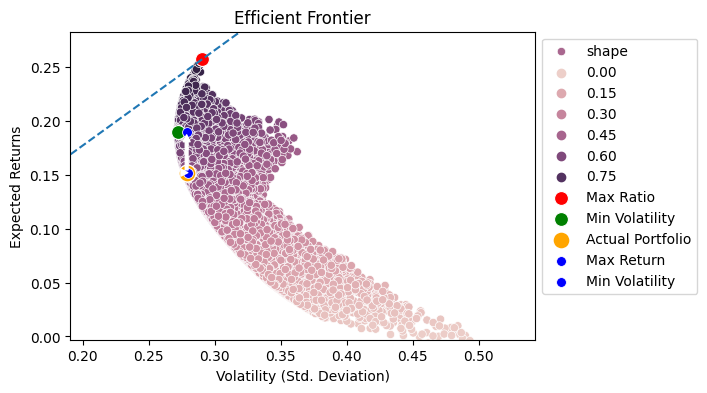

In [78]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
fig, ax = plt.subplots(figsize=(6, 4))

ax = sns.scatterplot(data=df, x='Volatility', y='Returns', hue='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', label="shape")
sns.scatterplot(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='o', s=100, label='Max Ratio')
sns.scatterplot(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='green', marker='o', s=100, label='Min Volatility')
sns.scatterplot(x=x_actual, y=y_actual, c='orange', marker='o', s=150, label='Actual Portfolio')
sns.lineplot(x=x_tangent, y=y_tangent , linestyle='--')

sns.scatterplot(x=max_return_for_volatility['Volatility'], y=max_return_for_volatility['Returns'], c='blue', marker='o', s=50, label='Max Return')
sns.scatterplot(x=min_volatility_for_return['Volatility'], y=min_volatility_for_return['Returns'], c='blue', marker='o', s=50, label='Min Volatility')


plt.annotate("", 
            xy=(max_return_for_volatility['Volatility'], max_return_for_volatility['Returns']),
            xytext=(x_actual[0], y_actual[0]),
            arrowprops=dict(arrowstyle="simple", color="white")
            )
plt.annotate("", 
            xy=(min_volatility_for_return['Volatility'],min_volatility_for_return['Returns']),
            xytext=(x_actual[0], y_actual[0]),
            arrowprops=dict(arrowstyle="simple", color="white")
            )


# Set the axis limits
plt.xlim(min_volatility * 0.7, max_volatility * 1.1)  # add some padding to the left and right
plt.ylim(min_return * 0.5, max_return * 1.1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [79]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)

                   689
Returns       0.189607
Volatility    0.272059
Sharpe Ratio  0.696933
AAL weight    0.096408
BABA weight   0.567836
META weight   0.181580
AAPL weight   0.154176
                 50519
Returns       0.257366
Volatility    0.290294
Sharpe Ratio  0.886569
AAL weight    0.007227
BABA weight   0.896511
META weight   0.006338
AAPL weight   0.089923


In [80]:
df.tail()

,Returns,Volatility,Sharpe Ratio,AAL weight,BABA weight,META weight,AAPL weight
59995,0.120946,0.290588,0.416211,0.232258,0.267751,0.306944,0.193047
59996,0.098750,0.309439,0.319125,0.263758,0.060751,0.297127,0.378365
59997,0.142454,0.288795,0.493270,0.249805,0.303007,0.133241,0.313946
59998,0.088549,0.319395,0.277240,0.399938,0.249879,0.278307,0.071876
59999,0.095375,0.319472,0.298539,0.371417,0.090068,0.168739,0.369776


NameError: name 'x_tg' is not defined

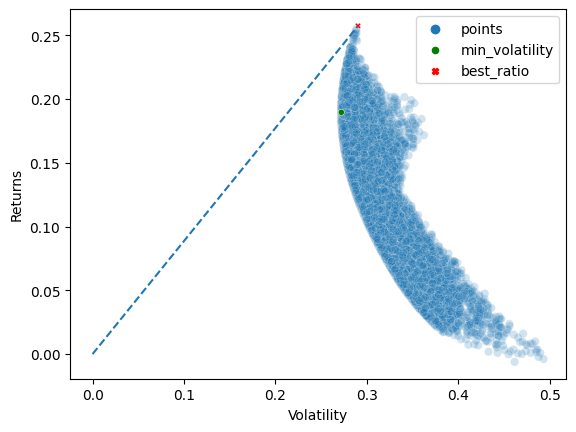

In [81]:
df['tags'] = 'points'

# min_volatility = df[df['Volatility']==df['Volatility'].min()].iloc[:,-len(tickers):].to_dict()
min_vol_index = (df['Volatility']==df['Volatility'].min())
df.loc[min_vol_index,'tags'] = 'min_volatility'
df.loc[min_vol_index]

max_ratio_index = (df['Returns']/df['Volatility']).idxmax()
df.loc[max_ratio_index, 'tags'] = 'best_ratio'
df.loc[max_ratio_index]

tangent = df.loc[(df['Returns']/df['Volatility']).idxmax()]


x_tangent = [0,tangent['Volatility']]
y_tangent = [0,tangent['Returns']]
# plot the efficient frontier with a scatter plot

ax = sns.scatterplot(data=df[df.tags=='points'], x='Volatility', y='Returns', hue='tags', alpha=0.2)

sns.scatterplot(data=df[df.tags!='points'], x='Volatility', y='Returns' , hue='tags', alpha=1, palette=["green","red"], size='tags',size_order=['min_volatility','best_ratio' ], sizes=(20,20), style = 'tags')
sns.lineplot(x=x_tangent, y=y_tangent , linestyle='--')


# Set the axis limits
plt.xlim(0.15, max(x_tg) * 1.1)  # add some padding to the left and right
plt.ylim(0.10, max(y_tg) * 1.1)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()
